In [1]:
!nvidia-smi

Tue Oct 24 14:37:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:05:00.0 Off |                  N/A |
|  0%   54C    P2    45W / 198W |   7696MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:06:00.0 Off |                  N/A |
| 35%   

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [4]:
class PolicyNetwork(nn.Module):
    def __init__(self):
        super(PolicyNetwork, self).__init__()

        self.fc = nn.Sequential()

        # First fully connected layer
        self.fc1 = nn.Linear(4, 128)
        nn.init.xavier_uniform_(self.fc1.weight)
        self.fc.add_module("fc1", self.fc1)
        self.fc.add_module("relu1", nn.ReLU())

        # Second fully connected layer
        self.fc2 = nn.Linear(128, 2)
        nn.init.xavier_uniform_(self.fc2.weight)
        self.fc.add_module("fc2", self.fc2)

    def forward(self, x):
        logits = self.fc(x)
        logits -= torch.max(logits, dim=-1, keepdim=True)[0]
        return F.softmax(logits, dim=-1)

In [5]:
class ValueNetwork(nn.Module):
    def __init__(self):
        super(ValueNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(4, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.fc(x)

In [6]:
def get_action(policy_net, state, method):
  if method == "random":
    action = env.action_space.sample()
  if method == "gradient":
    try:
        probs = policy_net(torch.tensor(state).unsqueeze(0).float().to(device))
    except:
        probs = policy_net(torch.tensor(state[0]).unsqueeze(0).float().to(device) )
    try:
      action = np.random.choice(2, p=probs.cpu().detach().numpy()[0])
    except:
      policy_net = PolicyNetwork()
      action = 0

  return action

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

policy_net = PolicyNetwork().to(device)
#policy_net = PolicyNetwork()
optimizer = optim.RMSprop(policy_net.parameters(), lr=0.001)

gamma = 0.95


policy_net

PolicyNetwork(
  (fc): Sequential(
    (fc1): Linear(in_features=4, out_features=128, bias=True)
    (relu1): ReLU()
    (fc2): Linear(in_features=128, out_features=2, bias=True)
  )
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [8]:
value_net = ValueNetwork().to(device)

value_optimizer = optim.RMSprop(value_net.parameters(), lr=0.001)

value_net

ValueNetwork(
  (fc): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [9]:
env = gym.make("CartPole-v0")

max = 195

longest_episode = 0
longest_episode_length = 0
longest_episode_path = ""
episode_lengths = []
loss_list = []
loss_avg = []
length_avg = []
value_list = []
val_avg = []

episode =  0
count = 0
cooldown = 0

/nfs/home/dwm7542/.conda/envs/mldsrl/lib/python3.8/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


In [10]:
print("Training...")
while True:
    
    state, _ = env.reset()
    episode_rewards = []
    saved_log_probs = []
    state_hist = []
    action_hist = []

    episode += 1
        
    cooldown -=1

    for t in range(1, 1000):
        state_hist.append(torch.FloatTensor(state).unsqueeze(0).to(device))
        
        action = get_action(policy_net, state, method = "gradient")
        state, reward, done, truncated, info = env.step(action)

        saved_log_probs.append(torch.log(policy_net(torch.from_numpy(state).float().unsqueeze(0).to(device))[0][action]))
        episode_rewards.append(reward)
        action_hist.append(action)
        
        if done or truncated:
            #print(f"Episode {episode + 1} finished after {t} time steps.")
            episode_lengths.append(t)
            length_avg.append(np.mean(episode_lengths[-100:]))

            if t > longest_episode_length:
                longest_episode_length = t
                longest_episode = episode

            break

    discounted_rewards = []
    R = 0
    for r in reversed(episode_rewards):
        R = r + gamma * R
        discounted_rewards.insert(0, R)

    discounted_rewards = torch.tensor(discounted_rewards)
    #discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)
    
    value_optimizer.zero_grad()
    value_preds = value_net(torch.cat(state_hist))
    value_loss = nn.MSELoss()(value_preds.to('cpu'), discounted_rewards.unsqueeze(1))
    value_loss.backward()
    value_optimizer.step()
    
    value_list.append(value_loss.cpu().detach().numpy())
    val_avg.append(np.mean(value_list[-100:]))
    
    advantages = discounted_rewards - value_preds.detach().squeeze().to('cpu')
    chosen_action_prob = policy_net(torch.cat(state_hist)).to('cpu').gather(1, torch.LongTensor(action_hist).view(-1, 1))
    policy_loss = -torch.mean(torch.log(chosen_action_prob) * advantages)
    
    loss_list.append(policy_loss.cpu().detach().numpy())
    loss_avg.append(np.mean(loss_list[-100:]))
    #print(f"Episode {episode + 1} policy loss: {policy_loss} value loss: {value_loss}")

    optimizer.zero_grad()
    policy_loss.backward()
    #nn.utils.clip_grad_norm_(policy_net.parameters(), max_norm=1)
    optimizer.step()

    if t >= max and cooldown <= 0:

      count +=1
      
      if count >= 10:
        
        cooldown = 10

        print(f"Testing on episode {episode +1}")

        test_lengths = []

        for test_count in range(100):

          state = env.reset()

          for t in range(1, 1000): 
            action = get_action(policy_net, state, method = "gradient")
            state, reward, done, truncated, info = env.step(action)
            
            if done or truncated:
                #print(f"Episode {episode + 1} finished after {t} time steps.")
                test_lengths.append(t)
                break

        test_average = sum(test_lengths) / 100
        print(f"Test on episode {episode +1}: Average per 100 = {test_average}")

        if test_average >= 195:

          state = env.reset()
          frames = []
          for t in range(1, 1000): 
            action = get_action(policy_net, state, method = "gradient")
            state, reward, done, truncated, info = env.step(action)

            if done or truncated:
              break
            
          break
    else:
        count = 0
    

env.close()

Training...


/nfs/home/dwm7542/.conda/envs/mldsrl/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Testing on episode 1012
Test on episode 1012: Average per 100 = 195.55


In [22]:
value_preds

tensor([[19.5842],
        [19.4164],
        [19.6000],
        [19.4296],
        [19.6132],
        [19.4409],
        [19.2612],
        [19.4721],
        [19.6527],
        [19.7730],
        [19.6804],
        [19.7285],
        [19.6115],
        [19.6677],
        [19.5743],
        [19.4033],
        [19.2321],
        [19.4389],
        [19.6268],
        [19.4484],
        [19.6364],
        [19.6295],
        [19.6235],
        [19.4437],
        [19.6342],
        [19.4524],
        [19.6434],
        [19.5709],
        [19.6195],
        [19.4466],
        [19.6143],
        [19.4549],
        [19.3028],
        [19.4835],
        [19.6255],
        [19.4870],
        [19.6208],
        [19.4902],
        [19.3423],
        [19.2018],
        [19.3882],
        [19.5556],
        [19.7169],
        [19.6706],
        [19.7115],
        [19.5260],
        [19.7105],
        [19.5250],
        [19.3599],
        [19.5456],
        [19.7220],
        [19.5397],
        [19.

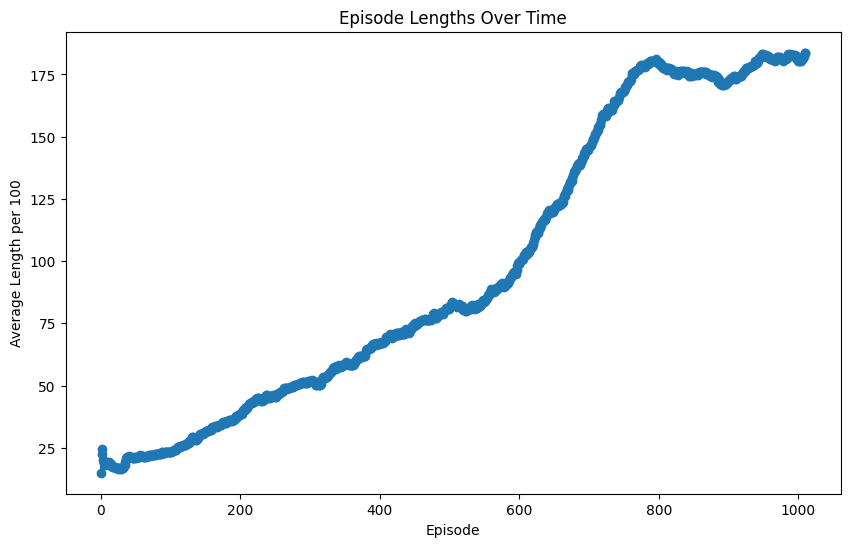

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(length_avg, marker='o')

plt.title('Episode Lengths Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Length per 100')
plt.savefig('results/cartpole_rolling_duration.png', dpi=300, format='png', bbox_inches='tight')

plt.show()



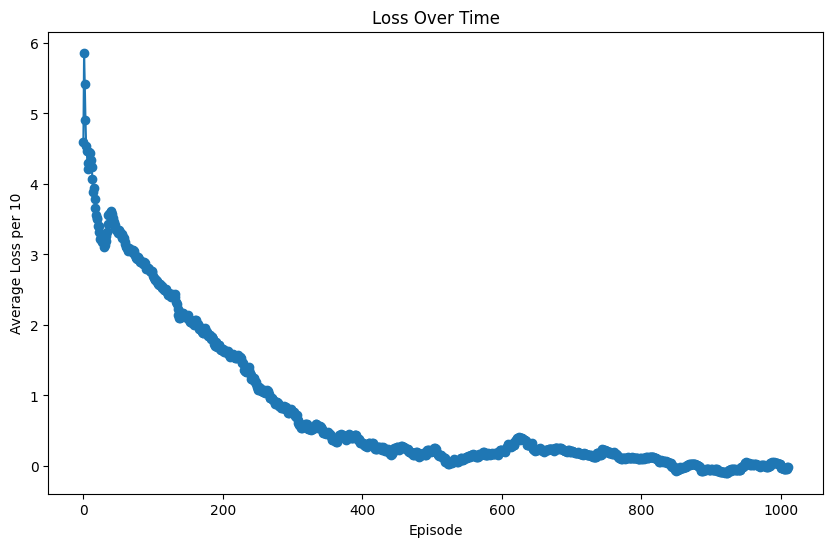

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(loss_avg, marker='o')

plt.title('Loss Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Loss per 10')
plt.savefig('results/cartpole_rolling_loss.png', dpi=300, format='png', bbox_inches='tight')

plt.show()


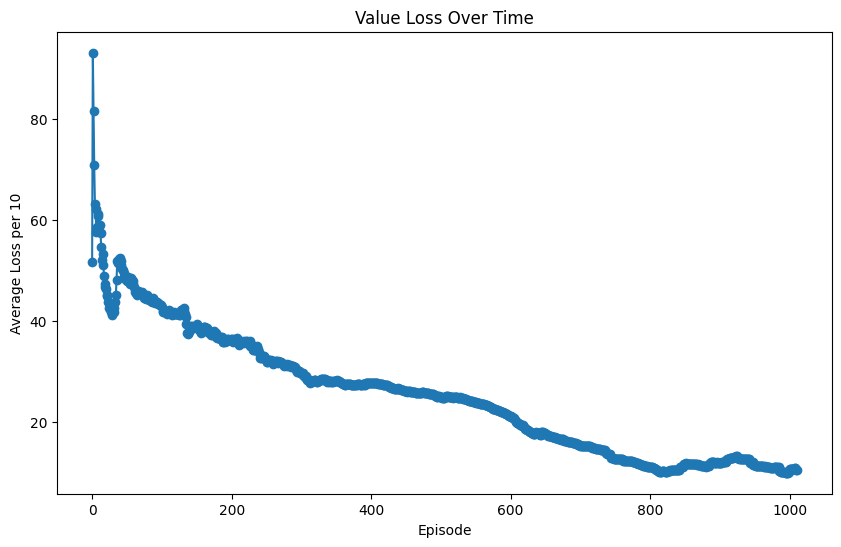

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(val_avg, marker='o')

plt.title('Value Loss Over Time')
plt.xlabel('Episode')
plt.ylabel('Average Loss per 10')
plt.savefig('results/cartpole_rolling_loss.png', dpi=300, format='png', bbox_inches='tight')

plt.show()
